Original notebook used for project. Very messy, but saving for records/snippets of code. All cleaned up code is in `kcomplex.ipynb` and `ripples.ipynb`.

In [1]:
import cv2
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from scipy.io import loadmat
from scipy.ndimage import convolve, gaussian_filter1d, gaussian_filter
from scipy.signal import butter, filtfilt, freqz, lfilter, spectrogram, iirnotch, hilbert, savgol_filter, normalize, resample
from scipy import stats
import statistics
import stumpy
from tslearn.clustering import TimeSeriesKMeans
from tqdm import tqdm

np.random.seed(0)
# %matplotlib widget
# %matplotlib ipympl

In [2]:
CAI_SB1 = "caillouSB1_1117.mat"
BLUE_SB2 = "blueSB2_0328.mat"
BLUE_LFP0_IDX = ["RSX", "RSX", "", "", "SMX", "SMX", "SMX", "SMX"]
BLUE_LFP1_IDX = ["SMX", "SMX", "HIP", "", "", "RSX", "RSX", "RSX"]
CAI_SB1_LFPJ_IDX = ["THA", "THA", "RSX", "RSX", "RSX", "RSX", "RSX", "RSX"]
CAI_SB1_LFPK_IDX = ["RSX", "RSX", "RSX", "RSX", "RSX", "RSX", "HIP", "HIP"]
CAI_SB1_LFP0_IDX = ["HIP"]*8
LFP_NAMES = ["adlfpj", "adlfpk", "arlfp0", "arlfp1"]

HC_FILTER_LOW = 100
HC_FILTER_HI = 250
HC_FILTER_ORDER = 9

In [3]:
def format_HIP_data(path):
    """Convert from .mat to df for HIP_LFP_rat3_1kHz.mat."""
    struct = loadmat(path)["lfp"]
    time = struct[0][0][0][0]
    lfp = struct[0][0][1].squeeze(1)
    return time, lfp

# def convert_to_df(time, lfp):
#     df = pd.DataFrame(data=np.array([time, lfp]).T, columns=["time", "lfp"])
#     return df

def butter_bandpass(lowcut, highcut, fs, order):
    return butter(order, [lowcut, highcut], fs=fs, btype='bandpass')

def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def butter_lowpass(cutoff, fs, order=3):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=3):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def filter(time, lfp, fs, lowcut, highcut, order):
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    w, h = freqz(b, a, fs=fs)
    return w, h

def get_data(sb1_struct, name=LFP_NAMES[0]):
    sb1_data = sb1_struct[name][0][0].data
    sb1_time = sb1_struct[name][0][0].timestamp.squeeze(0)    
    sample_rate = sb1_struct[name][0][0].samplerate[0][0]
    return sb1_time, sb1_data, sample_rate

def append_avg_rsx(sb1_data):
    """Append avg RSX to last row. Currend idx hard coded for sb1 adlfpk."""
    return np.append(sb1_data, np.mean(sb1_data[:, :6], axis=1, keepdims=True), axis=1)  # Avg of all RSX

def plot_all_traces_adlfpk(sb1_struct, title, xstart=None, xint=1, lines=None, ylim=(-0.6, 0.6), figsize=(10, 5)):
    """Lines is a list of x coords of lines to draw. (may need to be converted from index of array to x coords using sample freq)"""
    sb1_time, sb1_data, sample_rate = get_data(sb1_struct, name=LFP_NAMES[1])  # RSX and HIP
    sb1_data = append_avg_rsx(sb1_data)

    # Filter HIP data.
    sb1_data[:, 6] = butter_filter(sb1_data[:, 6], lowcut=HC_FILTER_LOW, highcut=HC_FILTER_HI, fs=sample_rate, order=HC_FILTER_ORDER, type="bandpass")
    sb1_data[:, 7] = butter_filter(sb1_data[:, 7], lowcut=HC_FILTER_LOW, highcut=HC_FILTER_HI, fs=sample_rate, order=HC_FILTER_ORDER, type="bandpass")

    fig, axes = plt.subplots(nrows=9, ncols=1, sharex=True)
    fig.canvas.header_visible = False
    fig.set_size_inches(figsize)

    for i, ax in enumerate(axes):
        ax.plot(sb1_time, sb1_data[:, i])
        if xstart is not None:  # If not defined will plot whole trace.
            ax.set_xlim(xstart+sb1_time[0], xstart+sb1_time[0]+xint)
        ax.set_ylim(ylim)

        # Plot points of interest
        # TODO need to scale c before input. in this function should only have /samplerate + init
        if lines:
            for line in lines:
                ax.axvline(line/sample_rate + sb1_time[0], color="red", lw=1)

        if i != len(axes)-1:
            # ax.set_xticks([])
            ax.set_ylabel(CAI_SB1_LFPK_IDX[i])
        else:
            ax.set_ylabel("RSX AVG")
            ax.set_xlabel("sec")
            ax.tick_params(axis="x")

        if i == 0:
            ax.set_title(title)
        
        if i in [6, 7]:
            ax.set_ylim(-0.1, 0.1)

def get_crossings_from_spec(spec_img, adapt_thresh=101, gauss_size=6, bin_thresh=210, plot=False):
    """Get crossings from manipulation of spectrogram of RSX. Could also do this by splitting into freq bands?"""
    if plot:
        plt.close()
        fig = plt.gcf()
        fig.canvas.header_visible = False
        plt.title("spectrogram of avg rsx")
        plt.imshow(spec_img)
        plt.show()

    gray_spec = cv2.cvtColor(spec_img, cv2.COLOR_BGR2GRAY) * 255
    thresh = cv2.adaptiveThreshold(np.uint8(
        gray_spec), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, adapt_thresh, 1)
    if plot:
        plt.title("spec binary threshold")
        plt.imshow(thresh)
        plt.show()

    gauss = gaussian_filter(thresh, gauss_size)
    if plot:
        plt.figure(figsize=(6, 2))
        plt.imshow(gauss, interpolation="nearest", aspect="auto")
        plt.title("gaussian blur")
        plt.show()

    gauss_mean = np.mean(gauss, axis=0)
    if plot:
        plt.figure(figsize=(6, 2))
        plt.imshow(np.expand_dims(gauss_mean, axis=1).T,
                interpolation="nearest", aspect="auto")
        plt.title("gauss mean")
        plt.show()

    # Simple binary thresholding.
    bin_thresh = np.where(gauss_mean > bin_thresh, 1, 0)
    if plot:
        bin_thresh_tiled = np.tile(bin_thresh.T, (200, 1))
        plt.imshow(bin_thresh_tiled)
        plt.title("binary threshold")
        plt.show()

    crossings = []
    for i in range(len(bin_thresh)-1):
        if bin_thresh[i] != bin_thresh[i+1]:
            crossings.append(i)

    return crossings

def sample_to_sec(sample, time):
    """time is the corresponding timestamps array"""
    return time[sample]

def sec_to_sample(sec, sr, t0):
    return int((sec-t0)*float(sr))

def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    np.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

def lfp_sample2fr_sample(lfp_sample, lfp_time, rsxfr_time):
    sec = lfp_time[lfp_sample]  # get time
    return sec_to_sample(sec, 1000, rsxfr_time[0])

def fr_sample2lfp_sample(fr_sample, lfp_time, rsxfr_time, sample_rate):
    sec = rsxfr_time[fr_sample]  # get time
    return sec_to_sample(sec, sample_rate, lfp_time[0])

def normalize(data):
    """normalize signal between 0 and 1"""
    return (data - np.min(data)) / (np.max(data) - np.min(data))


## HIP data

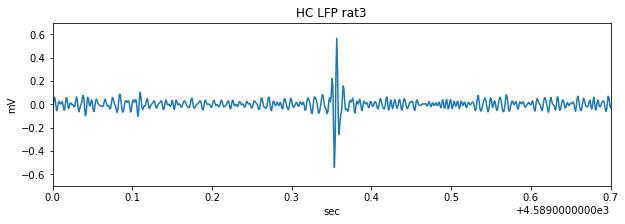

In [4]:
time, lfp = format_HIP_data(HC_LFP)

order = 9
fs = 1.001595549472272e+03
lowcut = 100
highcut = 250

# Sanity check filter 
# w, h = filter(time, lfp, fs=fs, lowcut=lowcut, highcut=highcut, order=order)
# plt.plot(w, abs(h))

filtered_lfp = butter_filter(lfp, lowcut=lowcut, highcut=highcut, fs=fs, order=order, type="bandpass")

fig, ax = plt.subplots()
fig.canvas.capture_scroll = True
fig.canvas.header_visible = False
fig.set_size_inches(10, 3)
# ax.set_xlim(time[0], time[0]+0.7)
ax.set_xlim(4589, 4589.7)  # arbitrary, just found a ripple here
ax.set_ylim(-0.7, 0.7)
ax.plot(time, filtered_lfp)
ax.set_title("HC LFP rat3");
ax.set_ylabel("mV");
ax.set_xlabel("sec");

## RSX LFP k-complex ID

In [5]:
# load lfp
blue_struct = loadmat(BLUE_SB2, struct_as_record=False)
time, data0, sample_rate = get_data(blue_struct, name=LFP_NAMES[2])  # LFP0
_, data1, _ = get_data(blue_struct, name=LFP_NAMES[3])  # LFP1

# load FR
smxfr_time = np.squeeze(blue_struct["SMXfr"][0][0].timestamp)
smxfr_count = np.squeeze(blue_struct["SMXfr"][0][0].count)
smxfr_data = np.squeeze(blue_struct["SMXfr"][0][0].data)

rsxfr_time = np.squeeze(blue_struct["RSXfr"][0][0].timestamp)
rsxfr_count = np.squeeze(blue_struct["RSXfr"][0][0].count)
rsxfr_data = np.squeeze(blue_struct["RSXfr"][0][0].data)

hcfr_time = np.squeeze(blue_struct["CA1fr"][0][0].timestamp)
hcfr_count = np.squeeze(blue_struct["CA1fr"][0][0].count)
hcfr_data = np.squeeze(blue_struct["CA1fr"][0][0].data)

# SWS = blue_struct["SWS"]
SWS = loadmat("SWS_0328.mat", struct_as_record=False)["SWS"]  # new definitions based on SMX

In [6]:
# average each region across lfp0 and lfp1
rsx_avg = np.mean(np.concatenate((data0[:, :2], data1[:, 5:]), axis=1), axis=1, keepdims=True)
smx_avg = np.mean(np.concatenate((data0[:, 4:], data1[:, :2]), axis=1), axis=1, keepdims=True)

# low pass filtering gets tiny values
# rsx_avg = butter_lowpass_filter(rsx_avg, 15, sample_rate, order=5)
# smx_avg = butter_lowpass_filter(smx_avg, 15, sample_rate, order=5)

hip = data1[:, 2]
hip = butter_filter(hip, lowcut=HC_FILTER_LOW, highcut=HC_FILTER_HI, fs=sample_rate, order=HC_FILTER_ORDER, type="bandpass")
hip = np.expand_dims(hip, axis=1)

# data = np.concatenate((smx_avg, rsx_avg, hip), axis=1)
# ylabels = ["SMX", "SMX FR" "RSX", "HIP"]

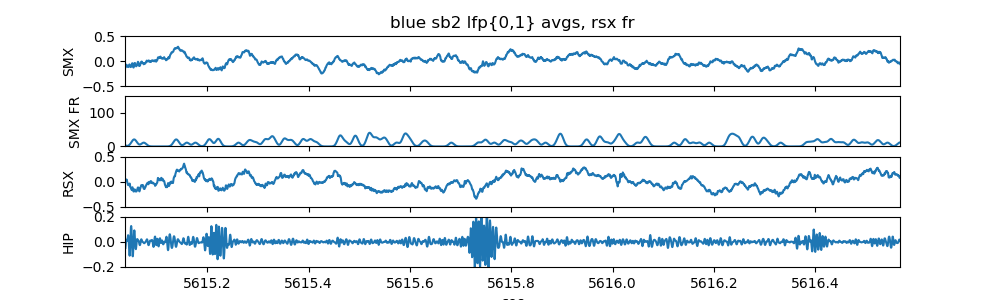

In [7]:
%matplotlib ipympl

# 13M+ points, let's just look at a subset
num_points = 1000000

plt.close()
fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True)
fig.canvas.header_visible = False
fig.set_size_inches((10, 3))
plt.xlim(SWS[1][0], SWS[1][1])

axes[0].plot(time[:num_points], smx_avg[:num_points])
axes[0].set_ylabel("SMX")
axes[0].set_ylim((-0.5, 0.5))
axes[0].set_title("blue sb2 lfp{0,1} avgs, rsx fr")

axes[1].plot(smxfr_time[:num_points], smxfr_data[:num_points])
axes[1].set_ylabel("SMX FR")
axes[1].set_ylim((0, 150))

axes[2].plot(time[:num_points], rsx_avg[:num_points])
axes[2].set_ylabel("RSX")
axes[2].set_ylim((-0.5, 0.5))

axes[3].plot(time[:num_points], hip[:num_points])
axes[3].set_ylabel("HIP")
axes[3].set_ylim((-0.2, 0.2))
axes[3].set_xlabel("sec")
axes[3].tick_params(axis="x")

In [7]:
# get fr supression windows
eps = 1e-3  # doesn't change much when decreasing more than 1e-3, omits many things if set abow 1e-1. but maybe should be lower, doesn't look like many k complexes for now
suppressed = np.where(smxfr_data <= eps, 1, 0)
print(np.sum(suppressed)/len(smxfr_time))

i = 0
prev = 0
ones_count = 0
thresh = 80  # must be 500+ (50ms) to qualify as an event block
blocks = []
while i < len(smxfr_data):
    if suppressed[i] == 1:
        ones_count+=1
    else:  # if current value is 0
        if prev == 1:
            if ones_count > thresh:
                blocks.append((i-1-ones_count, i-1))       
            ones_count = 0
    prev = suppressed[i]
    i+=1

print(len(blocks))

0.126164678689113
2827


NameError: name 'SWS' is not defined

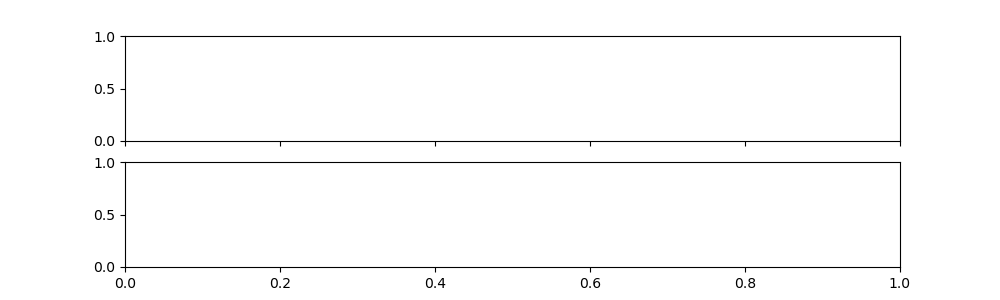

In [10]:
%matplotlib ipympl

SWS_idx = 50
# 13M+ points, let's just look at a subset
num_points = 1000000

plt.close()
# fig, axes = plt.subplots(nrows=5, ncols=1, sharex=True)
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)
fig.canvas.header_visible = False
fig.set_size_inches((10, 3))
plt.xlim(SWS[SWS_idx][0], SWS[SWS_idx][1])
# plt.xlim(8388.9224, 8389.2)
# plt.xlim(blocks[0][0]/1000 + smxfr_time[0], blocks[0][0]/1000 + smxfr_time[0]+4)
# plt.xlim(8445, 8449)
# plt.xlim(time[0], time[0]+1)

# axes[0].plot(time[:num_points], smx_avg[:num_points])
axes[0].plot(time, smx_avg)
axes[0].set_ylabel("SMX LFP")
axes[0].set_ylim((-0.5, 0.5))
# axes[0].set_title("blue sb2 lfp{0,1} avgs, smx fr")
axes[0].set_title("SMX LFP and FR")
for block in blocks:
    # axes[1].axvline(sample_to_sec(block[0], smxfr_time), color="green", lw=1)
    # axes[1].axvline(sample_to_sec(block[1], smxfr_time), color="red", lw=1)
    rect = Rectangle((sample_to_sec(block[0], smxfr_time), -1), width=(block[1]-block[0])/1000, height=2, facecolor='lightgrey')
    axes[0].add_patch(rect)

axes[1].plot(smxfr_time, smxfr_data)
axes[1].set_ylabel("SMX FR")
axes[1].set_ylim((0, 150))
for block in blocks:
    # axes[1].axvline(sample_to_sec(block[0], smxfr_time), color="green", lw=1)
    # axes[1].axvline(sample_to_sec(block[1], smxfr_time), color="red", lw=1)
    rect = Rectangle((sample_to_sec(block[0], smxfr_time), -1), width=(block[1]-block[0])/1000, height=150, facecolor='lightgrey')
    axes[1].add_patch(rect)
# for sleep in SWS:
#     axes[1].add_patch(Rectangle((sleep[0], 0), sleep[1]-sleep[0], 200, facecolor="lightgray", fill=True))

# axes[2].plot(time, rsx_avg)
# axes[2].set_ylabel("RSX")
# axes[2].set_ylim((-0.5, 0.5))

# axes[3].plot(rsxfr_time, rsxfr_data)
# axes[3].set_ylabel("RSX FR")
# axes[3].set_ylim((0, 150))

# axes[4].plot(time, hip)
# axes[4].set_ylabel("HIP")
# axes[4].set_ylim((-0.2, 0.2))
# axes[4].set_xlabel("sec")
# axes[4].tick_params(axis="x")

In [26]:
# def fr_sample2lfp_sample(fr_sample, lfp_time, rsxfr_time, sample_rate):
#     sec = rsxfr_time[fr_sample]  # get time
#     return sec_to_sample(sec, sample_rate, lfp_time[0])

#fr
print(blocks[0][0])

#lfp
sec = smxfr_time[blocks[0][0]]
print(sec)

print((sec-time[0])*sample_rate)
print(sec_to_sample(sec, sample_rate, smxfr_time[0]))
print(time[412623])
# print(time[fr_sample2lfp_sample(blocks[0][0], time, smxfr_time, sample_rate)])

211268
5676.2685
422536.7759735127
422536
5676.2685


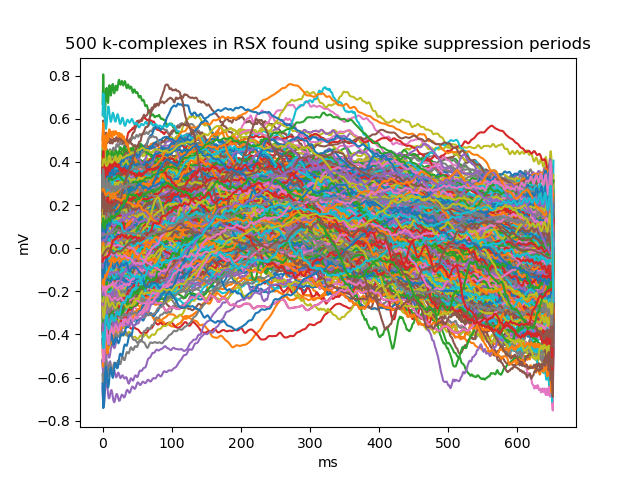

In [41]:
from scipy.interpolate import interp1d

plt.close()
# max = 0
# for block in blocks[:200]:
#     if block[1]-block[0] > max:
#         max = block[1]-block[0]
# max/=sample_rate
rtol = 1e-7
# max_len = 567
chunks = []
resampled_arr = []
for i in np.random.randint(0, len(blocks)-1, size=500):
    # t0 = sample_to_sec(block[0], smxfr_time)
    # s0 = sec_to_sample(t0, sample_rate, time[0])
    # t1 = sample_to_sec(block[1], smxfr_time)
    # s1 = sec_to_sample(t1, sample_rate, time[0])
    block = blocks[i]
    s0 = np.argwhere(np.isclose(smxfr_time[block[0]], time, rtol=rtol))[0][0]
    s1 = np.argwhere(np.isclose(smxfr_time[block[1]], time, rtol=rtol))[0][0]
    # s0 = fr_sample2lfp_sample(block[0], time, smxfr_time, sample_rate)
    # s1 = fr_sample2lfp_sample(block[1], time, smxfr_time, sample_rate)
    chunk = np.squeeze(smx_avg[s0:s1])
    chunks.append(chunk)
    # f = interp1d(np.linspace(0, len(chunk)-1, len(chunk)), chunk, fill_value="extrapolate")
    # interpd = f(np.linspace(0, int(max_len)-1, int(max_len)))
    # plt.plot(interpd)
    resampled = resample(chunk, 653)
    resampled_arr.append(resampled)
    plt.plot(resampled)
    # plt.plot(chunk)
plt.title("500 k-complexes in RSX found using spike suppression periods")
plt.ylabel("mV")
plt.xlabel("ms")
plt.show()

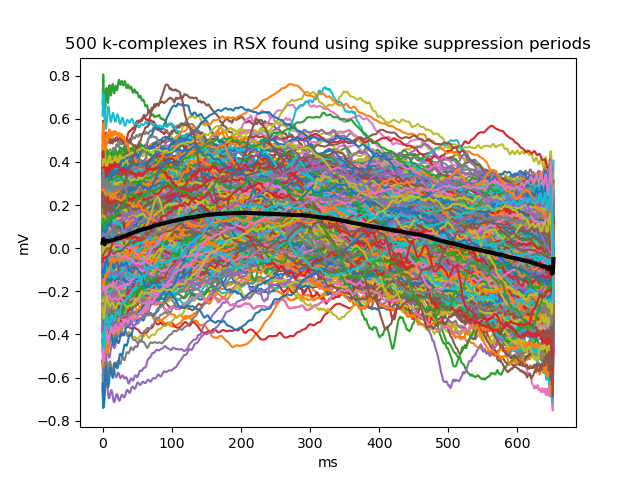

0.10005379890437364

In [43]:
plt.plot(np.mean(np.array(resampled_arr), axis=0), lw=3, color="black")
plt.show()
np.mean(np.array(resampled))

In [26]:
max_len = 0
for b in blocks:
    if b[1] - b[0] > max_len:
        max_len = b[1]- b[0]


print(max_len)

374


In [29]:
print(max_len)

653


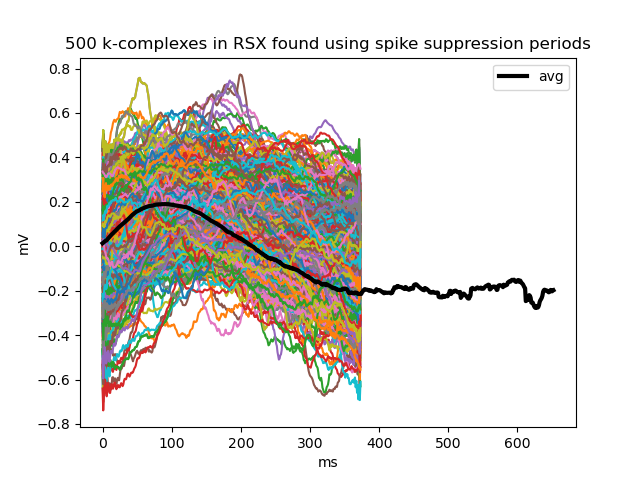

In [28]:
padded = []
# max_len = len(max(chunks, key=len))

max_len = 0
for c in chunks:
    if len(c) > max_len:
        max_len = len(c)

for c in chunks:
    padded.append(np.pad(c, (0, max_len-len(c)), constant_values=(np.nan)))

plt.plot(np.nanmean(padded, axis=0), lw=3, color="black", label="avg")
ax = plt.gca()
ax.legend()

plt.show()

/var/folders/0y/gsy94xwd3n70y8tm3t9zmdtw0000gn/T/ipykernel_88190/608103102.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  smx_extracted = np.array(rsx_extracted)


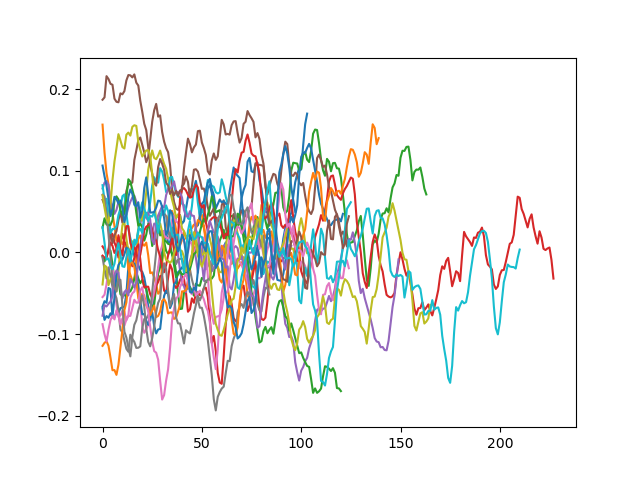

In [10]:
%matplotlib ipympl
# Extract patterns from SWS[226][0] to SWS[226][1]
rsx_extracted = []
block_lens = []
for block in blocks:
    if (block[0] >= (SWS[SWS_idx][0]-smxfr_time[0])*1000) and (block[0] <= (SWS[SWS_idx][1]-smxfr_time[0])*1000):
        rsx_extracted.append(rsx_avg[block[0]:block[1]])
        block_lens.append((block[1]-block[0])/1000)  # in s
median_len = np.median(block_lens)
smx_extracted = np.array(rsx_extracted)
block_lens = np.array(block_lens)

block_large = smx_extracted[np.where(block_lens <= median_len)[0]]
block_small = smx_extracted[np.where(block_lens > median_len)[0]]

plt.close()
# plt.axvline(median_len, color="red")
# plt.hist(block_lens, bins=100)
# plt.show()


# for block in block_large:
#     plt.plot(block)
# plt.show()

for block in rsx_extracted:
    plt.plot(block)
plt.show()
fig = plt.gcf()
fig.set_size_inches(10, 3)

In [ ]:
plt.close()

fig = plt.gcf()
fig.set_size_inches((10, 3))
fig.canvas.header_visible = False
rsx_filtered = butter_bandpass_filter(np.squeeze(rsx_avg), highcut=20, lowcut=6, fs=sample_rate, order=3)
spec, freqs, t, im = plt.specgram(np.squeeze(rsx_avg), NFFT=256, Fs=int(sample_rate))
# plt.show()
# plt.plot(time, rsx_filtered)
# plt.plot(time, rsx_avg)

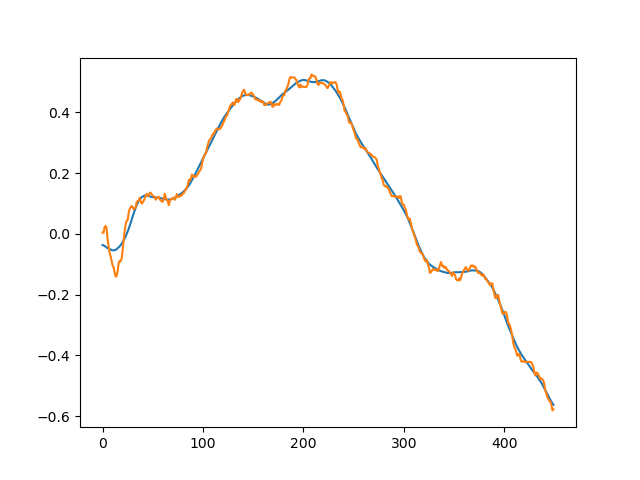

In [12]:
# first try low pass to get overall shape
# filtered = butter_lowpass_filter(smx_avg, 900, sample_rate, order=5)
smoothed = savgol_filter(np.squeeze(smx_avg), window_length=51, polyorder=3)
plt.close()
plt.plot(smoothed[sec_to_sample(8388.93, sample_rate, time[0]):sec_to_sample(8389.155, sample_rate, time[0])])
plt.plot(smx_avg[sec_to_sample(8388.93, sample_rate, time[0]):sec_to_sample(8389.155, sample_rate, time[0])])


## plot all data for slide

Text(0.5, 0, 'sec')

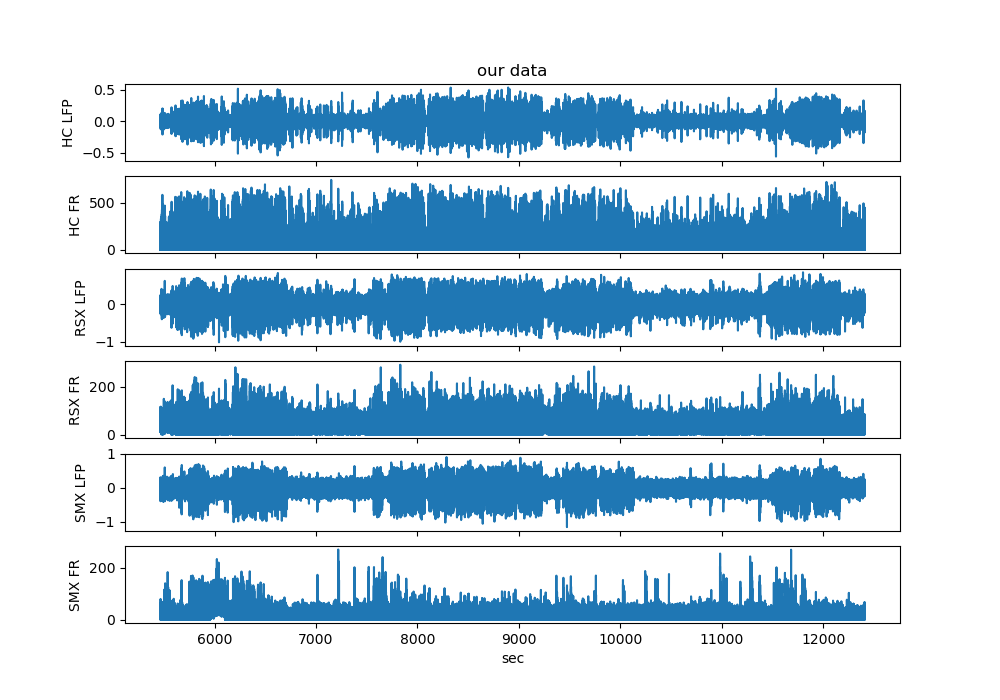

In [11]:
# hc lfp, hc fr, rsx lfp, rsx fr, smx lfp, smx fr

fig, axes = plt.subplots(nrows=6, ncols=1, sharex=True)
fig.canvas.header_visible = False
fig.set_size_inches((10, 7))

axes[0].set_title("our data")
axes[0].plot(time, hip)
axes[0].set_ylabel("HC LFP")

axes[1].plot(hcfr_time, hcfr_data)
axes[1].set_ylabel("HC FR")

axes[2].plot(time, rsx_avg)
axes[2].set_ylabel("RSX LFP")

axes[3].plot(rsxfr_time, rsxfr_data)
axes[3].set_ylabel("RSX FR")

axes[4].plot(time, smx_avg)
axes[4].set_ylabel("SMX LFP")

axes[5].plot(smxfr_time, smxfr_data)
axes[5].set_ylabel("SMX FR")
axes[5].set_xlabel("sec")

## motif detection k complex

In [8]:
# try motif detection

num_points = 100000
mp = stumpy.stump(np.squeeze(smx_avg[num_points:num_points*4]), m=450)
# mp = stumpy.stump(np.squeeze(rsx_avg[sec_to_sample(SWS[SWS_idx][0], sample_rate, time[0]):sec_to_sample(SWS[SWS_idx][1], sample_rate, time[0])]), m=450)


In [10]:
%matplotlib ipympl
# motifs = stumpy.motifs(np.squeeze(rsx_avg[num_points:num_points*7]), mp[:,0], max_matches=10, max_motifs=5)
# print(motifs[1].shape)
# plt.close()
# for match in motifs[1][0]:
#     plt.plot(smx_avg[match:match+450])

# query = savgol_filter(np.squeeze(smx_avg[sec_to_sample(8388.93, sample_rate, time[0]):sec_to_sample(8389.155, sample_rate, time[0])]), window_length=101, polyorder=3)
query = np.squeeze(smx_avg[sec_to_sample(8388.94, sample_rate, time[0]):sec_to_sample(8389.155, sample_rate, time[0])])
print(query.shape)
matches = stumpy.match(np.squeeze(query), np.squeeze(smx_avg))
# matches = stumpy.match(np.squeeze(query), savgol_filter(np.squeeze(smx_avg[smx_k[k_idx][0]:smx_k[k_idx][0]+20000]), window_length=101, polyorder=3))


(430,)


7221


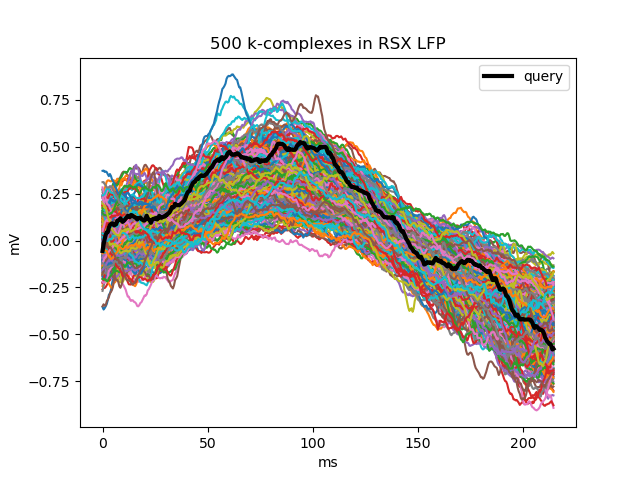

In [12]:
plt.close()
# query = smx_avg[sec_to_sample(8144.2, sample_rate, time[0]):sec_to_sample(8144.6, sample_rate, time[0])]
print(len(matches))
for match in matches[:500]:
    plt.plot(np.arange(0, (len(query))/sample_rate, 1./sample_rate)*1000, smx_avg[match[1]:match[1]+len(query)])
plt.plot(np.arange(0, (len(query))/sample_rate, 1./sample_rate)*1000, query, lw=3, color="black", label="query")
plt.title("500 k-complexes in SMX LFP")
plt.ylabel("mV")
plt.xlabel("ms")
ax = plt.gca()
ax.legend()
plt.show()

In [14]:
smx_k = []
for match in matches:
    smx_k.append((match[1], match[1]+450))

print(len(smx_k))

7221


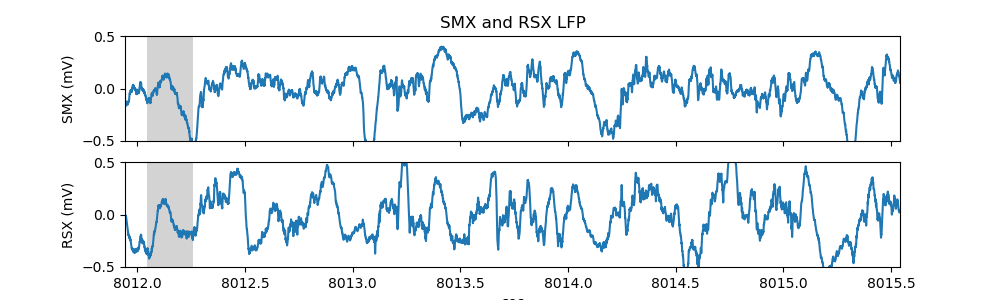

In [15]:
%matplotlib ipympl
k_idx = 20

plt.close()
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)
fig.canvas.header_visible = False
fig.set_size_inches((10, 3))
# plt.xlim(SWS[SWS_idx][0], SWS[SWS_idx][1])
plt.xlim(time[smx_k[k_idx][0]]-0.1, time[smx_k[k_idx][0]]+3.5)
# plt.xlim(8388.9224, 8389.2)
# plt.xlim(blocks[2][0]/1000 + smxfr_time[0], blocks[2][0]/1000 + smxfr_time[0]+4)
# plt.xlim(8445, 8449)
# plt.xlim(time[0], time[0]+1)

# axes[0].plot(time[:num_points], smx_avg[:num_points])
axes[0].plot(time, smx_avg)
axes[0].set_ylabel("SMX (mV)")
axes[0].set_ylim((-0.5, 0.5))
# axes[0].set_title("blue sb2 lfp{0,1} avgs, smx fr")
axes[0].set_title("SMX and RSX LFP")
for k in smx_k[:100]:
    rect = Rectangle((sample_to_sec(k[0], time), -1), width=len(query)/sample_rate, height=3, facecolor='lightgrey')
    axes[0].add_patch(rect)
    # axes[0].axvline(time[k[0]], color="green", lw=1)
    # axes[0].axvline(time[k[1]], color="red", lw=1)

axes[1].plot(time, rsx_avg)
axes[1].set_ylabel("RSX (mV)")
axes[1].set_ylim((-0.5, 0.5))
axes[1].set_xlabel("sec")
axes[1].tick_params(axis="x")
for k in smx_k[:100]:
    rect = Rectangle((sample_to_sec(k[0], time), -1), width=len(query)/sample_rate, height=3, facecolor='lightgrey')
    axes[1].add_patch(rect)
    # axes[1].axvline(time[k[0]], color="green", lw=1)
    # axes[1].axvline(time[k[1]], color="red", lw=1)


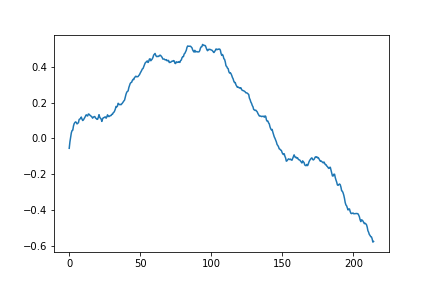

In [31]:
%matplotlib ipympl
# print(time[smx_k[k_idx+100][0]]-sample_to_sec(smx_k[k_idx+100][0], sample_rate, time[0]))
# print(time[smx_k[k_idx][0]]-sample_to_sec(smx_k[k_idx][0], sample_rate, time[0]))
plt.plot(np.arange(0, (len(query)-1)/sample_rate, 1./sample_rate)*1000, query)
plt.show()

## try clustering on SMX LFP

In [10]:
model = TimeSeriesKMeans(n_clusters=5, metric="dtw",
                         max_iter=10, random_state=0)
labels = model.fit_predict(np.reshape(smx_avg[:10000], (1, 10000, 1)))  # n_ts, size, dim

KeyboardInterrupt: 

Euclidean k-means
16.434 --> 9.437 --> 9.437 --> 
DBA k-means
Init 1
0.637 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

0.458 --> 0.458 --> 
Init 2
0.826 --> 0.525 --> 0.477 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished


0.472 --> 0.472 --> 
Soft-DTW k-means
0.472 --> 0.144 --> 0.142 --> 0.143 --> 0.142 --> 0.143 --> 0.142 --> 0.143 --> 0.142 --> 0.142 --> 0.142 --> 0.142 --> 0.142 --> 0.142 --> 0.142 --> 0.142 --> 0.142 --> 0.142 --> 0.142 --> 0.142 --> 0.142 --> 


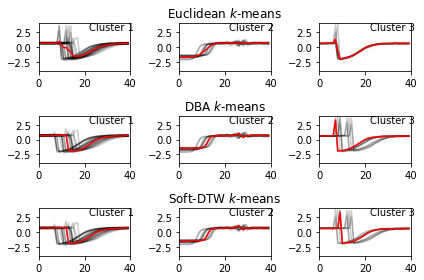

In [28]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler

seed = 0
np.random.seed(seed)
X_train, y_train, X_test, y_test = CachedDatasets().load_dataset("Trace")
X_train = X_train[y_train < 4]  # Keep first 3 classes
np.random.shuffle(X_train)
# Keep only 50 time series
X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train[:50])
# Make time series shorter
X_train = TimeSeriesResampler(sz=40).fit_transform(X_train)
sz = X_train.shape[1]

# Euclidean k-means
print("Euclidean k-means")
km = TimeSeriesKMeans(n_clusters=3, verbose=True, random_state=seed)
y_pred = km.fit_predict(X_train)

plt.figure()
for yi in range(3):
    plt.subplot(3, 3, yi + 1)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=3,
                          n_init=2,
                          metric="dtw",
                          verbose=True,
                          max_iter_barycenter=10,
                          random_state=seed)
y_pred = dba_km.fit_predict(X_train)

for yi in range(3):
    plt.subplot(3, 3, 4 + yi)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DBA $k$-means")

# Soft-DTW-k-means
print("Soft-DTW k-means")
sdtw_km = TimeSeriesKMeans(n_clusters=3,
                           metric="softdtw",
                           metric_params={"gamma": .01},
                           verbose=True,
                           random_state=seed)
y_pred = sdtw_km.fit_predict(X_train)

for yi in range(3):
    plt.subplot(3, 3, 7 + yi)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(sdtw_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Soft-DTW $k$-means")

plt.tight_layout()
plt.show()

(10000,)


(1004, 1)

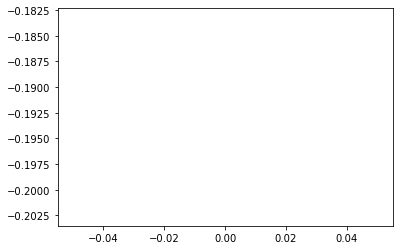

In [40]:
# for i in range(5):
#     for xx in smx_avg[:10000][labels == i]:
#         plt.plot(xx.ravel(), "k-", alpha=.2)
#     plt.plot(model.cluster_centers_[i].ravel(), "r-")
#     # plt.xlim(0, 10000)
#     plt.ylim(-4, 4)
#     plt.text(0.55, 0.85,'Cluster %d' % (i + 1),
#              transform=plt.gca().transAxes)
#     if i == 1:
#         plt.title("DBA $k$-means")
#     plt.show()

plt.close()
# for cluster0 in smx_avg[:10000][labels == 0]:
    # plt.plot(cluster0)
plt.plot(model.cluster_centers_[0])
print(labels.shape)
model.cluster_centers_[0].shape
smx_avg[:10000][labels==0].shape

## RSX sleep vs awake

In [4]:
sb1_struct = loadmat(CAI_SB1, struct_as_record=False)
sb1_time, sb1_data, sample_rate = get_data(sb1_struct, name=LFP_NAMES[1])  # RSX and HIP

In [ ]:
%matplotlib ipympl
plt.close()

plot_all_traces_adlfpk(sb1_struct, xstart=0, xint=2, title="sb1 adlfpk")

sleeping or not? soose definition
SWS

for RSX or THA, not so much for HIP:
low pass filter 6-8 hz.anything above mean consider sleep
define min duration? multiple 10s windows, continuous

RSX, HC, and THA:
theta (8-12hz) to delta (up to 4h) ratio. take envelope, 1s sliding window. get distribution, maybe get bimodal dist?
union or intersection?

hierarchies? wake vs sleep using thresholding and filtering.
second level: within sleep definitions, additional info

theta: moving, doing anything, all spiking modulated by theta
sleep: theta doesn't happen as much, more delta.


LFP HC:
sharp wave ripple 8-10hz
filter in 100-250
then get distribution (take envelope or power. ) . then define ripple as crossing some threshold. 3-5, maybe even 6std above mean. when it's at mean, starts and end

bursts of ripples (2, 3, etc) - if look at RSX, see similar modulation (Firing Rate local maximum, peak - 10z is freq band of spindles), maybe 1:1? windows of heightened communication? 

do bursts in FR coincide/correspond with spindle activity? just coincidence? corticcal burst correlate with 10z fr.

ripples happen both before and after kcomplex
ripples tend to happen beginnings and ends of sleep periods?

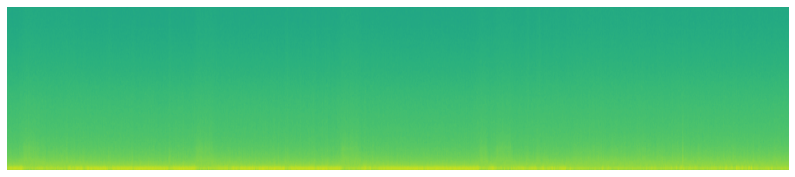

In [9]:
# %matplotlib ipympl
%matplotlib inline
sb1_data = append_avg_rsx(sb1_data)

plt.close()
fig = plt.gcf()
fig.canvas.header_visible = False
ax = plt.gca()
fig.set_size_inches(14, 3)
spec, freqs, t, im = plt.specgram(sb1_data[:, -1], NFFT=256, Fs=int(sample_rate))
ax.axis("off")
plt.xticks([])
plt.yticks([])
plt.savefig("sb1_lfpk_rsx_avg.png", bbox_inches='tight', pad_inches=0.)
# plt.colorbar()
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')
# plt.ylim([0, 0.4])

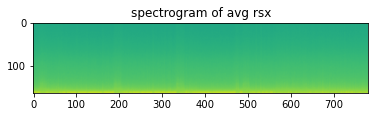

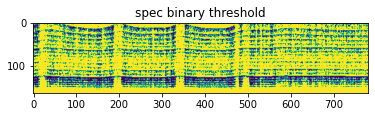

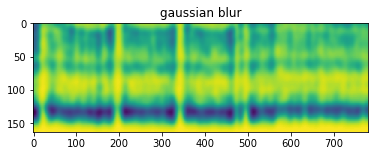

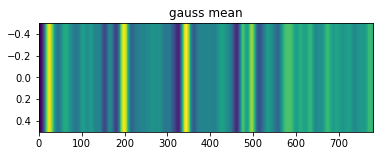

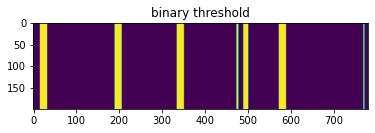

[15, 32, 189, 206, 334, 351, 473, 478, 489, 501, 572, 589, 769, 772]


In [10]:
%matplotlib inline
spec_img = plt.imread("sb1_lfpk_rsx_avg.png")
crossings = get_crossings_from_spec(spec_img, plot=True)
print(crossings)

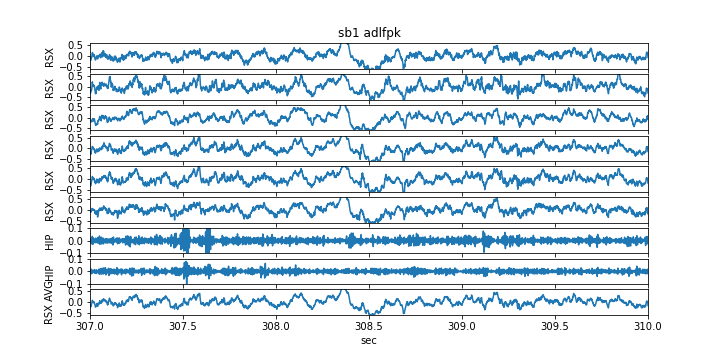

In [12]:
%matplotlib ipympl
plt.close()

spec_len = spec_img.shape[1]
ratio = spec_len/len(sb1_time) 
lines = [c/ratio for c in crossings]

plot_all_traces_adlfpk(sb1_struct, title="sb1 adlfpk", xstart=307, xint=3, lines=lines)

Next:
- Average all RSX for simplification?
- Try stumpy?
- Try other fourier methods, umap?
- Idea from Matt talk: model using different timescales of HMMs. Talk to Noga?

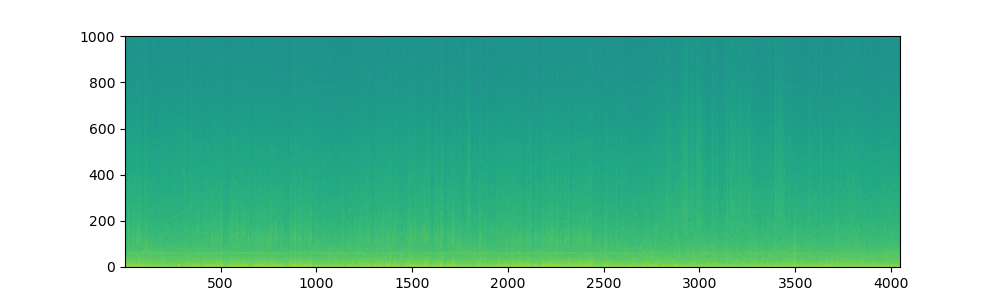

In [28]:
# Try spec of HMM using different NFFT
%matplotlib ipympl

# Filter HC
# sb1_data[:, 6] = butter_bandpass_filter(sb1_data[:, 6], lowcut=HC_FILTER_LOW, highcut=HC_FILTER_HI, fs=sample_rate, order=HC_FILTER_ORDER)
# sb1_data[:, 7] = butter_bandpass_filter(sb1_data[:, 7], lowcut=HC_FILTER_LOW, highcut=HC_FILTER_HI, fs=sample_rate, order=HC_FILTER_ORDER)
spec, freqs, t, im = plt.specgram(sb1_data[:, 6], NFFT=1028, Fs=int(sample_rate))
fig = plt.gcf()
fig.set_size_inches((10, 3))
fig.canvas.header_visible = False


## RSX firing rates

In [6]:
sb1_struct = loadmat(CAI_SB1, struct_as_record=False)
sb1_time, sb1_data, sample_rate = get_data(sb1_struct, name=LFP_NAMES[1])  # RSX and HIP

999.9999999952252


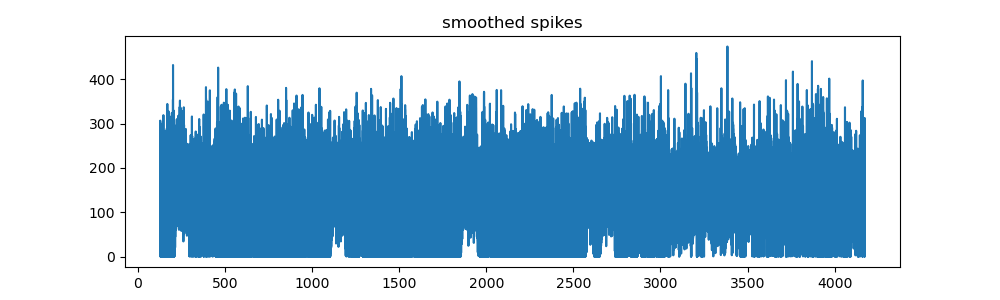

: 

In [20]:
%matplotlib ipympl

plt.close()
time = np.squeeze(sb1_struct["RSXfr"][0][0].timestamp)
count = np.squeeze(sb1_struct["RSXfr"][0][0].count)
data = np.squeeze(sb1_struct["RSXfr"][0][0].data)

print(1/(time[1]-time[0]))

# print(count.shape)
# print(count)

# plt.plot(np.squeeze(time), np.squeeze(count))
# plt.show()

# spec, freqs, t, im = plt.specgram(count, NFFT=256, Fs=1000)

filtered = butter_filter(data, 7, 14, fs=1000, order=3, type="bandpass")
plt.plot(time, data)
fig = plt.gcf()
fig.canvas.header_visible = False
fig.set_size_inches((10, 3))
envelope = np.abs(hilbert(filtered))
window_len=1001
y = smooth(envelope, window_len=window_len, window="bartlett")
smoothed = y[int(np.ceil((window_len/2-1))):-(window_len//2)]
# std = statistics.stdev(smoothed)
# mean = np.mean(smoothed)

# plt.plot(time, envelope)
# plt.plot(time, smoothed)
# plt.xlim(288, 300)
plt.title("smoothed firing rate RSX")
plt.show()

# ec, freqs, t, im = plt.specgram(filtered, NFFT=256, Fs=1000)


look at RSX LFP and RSX spikes at same time - can see k complexes

RSX LFP - smooth or remove high freqs. look at times when have large wave in pos dir followed by large drop in negative direction
suppresion of spiking corresponds to 

motif - eg larger and more spaced out correspond to k complexes?
shorter eg might correspond to other spectral properties around those 

look at k complexes in somatosensory cortex, by comparison rsx that has many links in hc that has more strucutre in sleep
how does finer structure relate to HC acitvity 

angle:
delta in cortex and relationship to ripples in HC
spindles (like ripples but slower, 10-15hz)
story: riipples happen a little before or after delta waves. this is established
ripple bursts - HIP FR. see nice peaks around ripples.
ID a bunch of ripple bursts, then compute avg FR at start of ripple. then find nice relationship. when 3 ripples, get 3 nice peaks.

same in RSX - interpeak interval shoul dbe in 10-15hz band
say we see some ripples, we know they happen around delta. what does RSX do? is it modulted by ripples or unrelated

HC spiking 
see if RSX FR correspond with RSX LFP with 10hz oscillation with consistent shape an dduration
look at things relative to somatosensory. somatosensory is longer structure. then can tie to whatever happening in RSX. hierarchy

use motif detector to detect upstate, downstates in somatosens
go and look at correpsonding times in rsx. how many of sustains spiking between upstates as opposed to maybe has additional downstate in rsx when there isn't one in somatosense. 2 groups

define slow osc by somatosense. when look at rsx, look at different types of updates. some have short bursts, may have relationships to lfp. 

then link to ripples. when i get one ripple it happens x
what aobut multiple ripples? when do they happen? in two types of groups?

blue0328

In [18]:
std = statistics.stdev(smoothed)
mean = np.mean(smoothed)
print(std)
print(statistics.stdev(envelope))
# print(np.mean(envelope))

11.685022185573896
18.71244360687794


## HC LFP ripple detection

In [16]:
sb1_struct = loadmat(CAI_SB1, struct_as_record=False)
sb1_time, sb1_data, sample_rate = get_data(sb1_struct, name=LFP_NAMES[1])  # RSX and HIP
# Filter HC 
sb1_data[:, 6] = butter_filter(sb1_data[:, 6], lowcut=HC_FILTER_LOW, highcut=HC_FILTER_HI, fs=sample_rate, order=HC_FILTER_ORDER, type="bandpass")
sb1_data[:, 7] = butter_filter(sb1_data[:, 7], lowcut=HC_FILTER_LOW, highcut=HC_FILTER_HI, fs=sample_rate, order=HC_FILTER_ORDER, type="bandpass")

In [17]:
%matplotlib ipympl 

plt.close()
lfp = sb1_data[:, 6]
power = np.abs(lfp)**2
analytic_signal = hilbert(lfp, N=len(lfp//1000))
# plt.plot(sb1_time, analytic_signal)
amplitude_envelope = np.abs(analytic_signal)
std = statistics.stdev(amplitude_envelope)
mean = np.mean(amplitude_envelope)
# print(np.mean(amplitude_envelope))
# print(np.mean(power))
# plt.plot(sb1_time, power)


0.025601812294707274


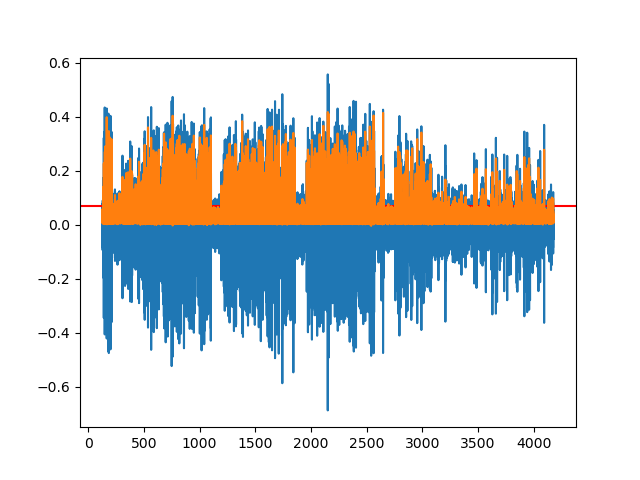

In [18]:
plt.close()
print(std)
# plt.plot(sb1_time, power, label="signal")
plt.plot(sb1_time, lfp, label="signal")
# plt.axhline(mean + 5*std, color="r")
# plt.plot(sb1_time, amplitude_envelope, label="envelope")
# maybe use a different smoothing technique, but probalby better just to do some kind of thresholding about how many times crossing this line?
smoothed = savgol_filter(amplitude_envelope, 101, 3)
std = statistics.stdev(smoothed)
plt.axhline(mean + 2*std, color="r")
plt.plot(sb1_time, smoothed)
# plt.plot(sb1_time, amplitude_envelope)
plt.show()

In [19]:
# classify ripples
thresh = mean + 2*std
ripples = np.where(smoothed >= thresh, 1, 0)
# print(np.sum(ripples)/len(amplitude_envelope)) # percentage of points that qualify as ripples
boundaries_list = []

for i in range(len(amplitude_envelope)-1):
    if ripples[i] != ripples[i+1]:
        boundaries_list.append(i)
boundaries = [tuple(boundaries_list[i:i+2]) for i in range(0, len(boundaries_list), 2) ]

In [20]:
# merge ripples
min_dist = sample_rate * 0.2 # 250ms

# approach 1
# close = np.zeros(len(boundaries))
# for i in np.linspace(0, len(boundaries)-3, (len(boundaries))//2, dtype=np.int64):
#     if boundaries[i+2] - boundaries[i] < min_dist:
#         close[i] = 1

# merged = []
# while i < len(close):
#     if close[i] == 1:
#         j = 1
#         cluster = 0
#         while close[i+j] == 1:
#             j+=1
#             cluster+=1
#         if cluster >= 1:
#             merged.append(boundaries[i])
#             merged.append(boundaries[i+cluster])
#             i+=cluster+1
#         else:
#             merged.append(boundaries[i])
#             merged.append(boundaries[i+1])
#             i+=2
#     else:
#         i+=2

# approach 2        
merged = []
i = 0
while i < len(boundaries)-2:
    dist = boundaries[i+1][0]-boundaries[i][0]  # distance between current and next ripple beginning
    if dist < min_dist:
        j = 0
        while boundaries[i+j+1][0] - boundaries[i+j][0] < min_dist:
            j+=1
        merged.append(boundaries[i][0])
        merged.append(boundaries[i+j][1])
        i+=1+j
    else:  
        merged.append(boundaries[i][0])
        merged.append(boundaries[i][1])
        i+=1

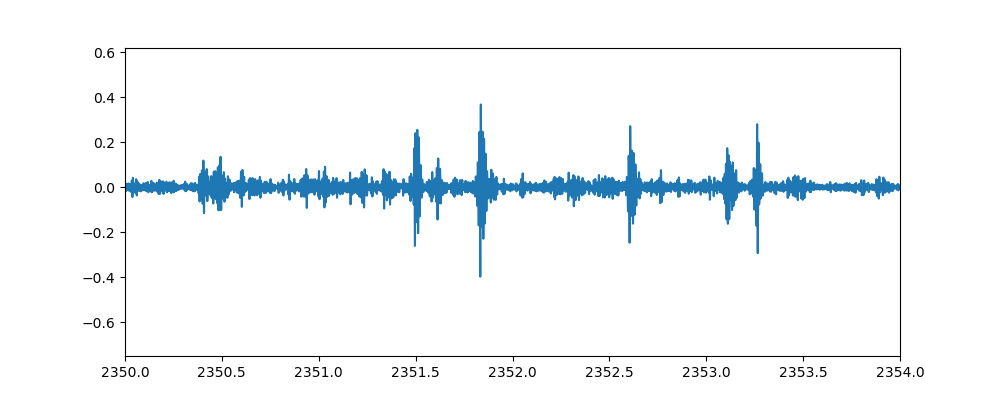

In [10]:
# Plot ripple boundaries on HC LFP
plt.close()
ax = plt.gca()
fig = plt.gcf()
plt.plot(sb1_time, lfp)
plt.xlim(2350, 2354)
fig.set_size_inches((10, 4))
plt.show()
# for line in boundaries_list:
for line in merged:
    ax.axvline(sb1_time[line], color="red", lw=1, alpha=0.2)



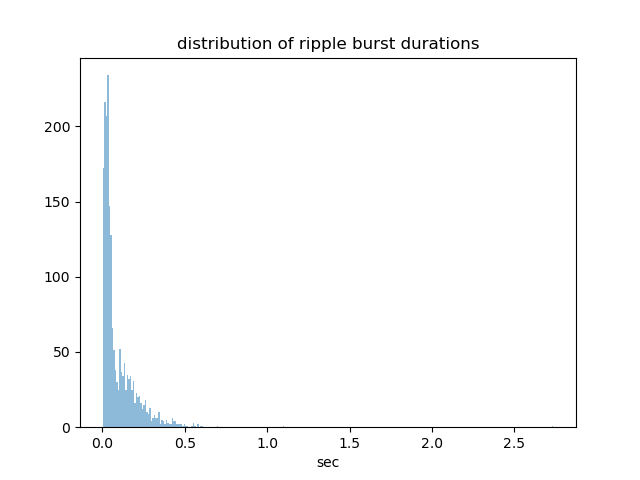

In [21]:
# now plot distribution
plt.close()
distances_orig = []
distances_merged = []
for i in np.linspace(0, len(boundaries_list)-2, (len(boundaries_list))//2, dtype=np.int64):
    distances_orig.append(boundaries_list[i+1]-boundaries_list[i])
# plt.hist(distances_orig, bins=300)

for i in np.linspace(0, len(merged)-2, (len(merged))//2, dtype=np.int64):
    distances_merged.append(merged[i+1]-merged[i])
plt.hist(np.array(distances_merged)/sample_rate, bins=300, alpha=0.5)
# plt.axvline(np.median(distances_merged))
plt.title("distribution of ripple burst durations")
plt.xlabel("sec")
plt.show()

In [22]:
# thresholds:
thresh0 = 280
thresh1 = 480
thresh2 = 800

plt.close()
distances_merged = np.array(distances_merged)
singles = distances_merged < thresh0
doubles = np.asarray(np.logical_and(distances_merged >= thresh0, distances_merged < thresh1))
triples = np.asarray(np.logical_and(distances_merged >= thresh1, distances_merged < thresh2))
longs = distances_merged >= thresh2
print(np.sum(singles))
print(np.sum(doubles))
print(np.sum(triples))
print(np.sum(longs))

merged = np.array(merged)

singles_doubled = []
for d in singles:
    singles_doubled.append(d)
    singles_doubled.append(d)
singles_doubled = merged[np.array(singles_doubled)]

doubles_doubled = []
for d in doubles:
    doubles_doubled.append(d)
    doubles_doubled.append(d)
doubles_doubled = merged[np.array(doubles_doubled)]

triples_doubled = []
for d in triples:
    triples_doubled.append(d)
    triples_doubled.append(d)
triples_doubled = merged[np.array(triples_doubled)]

longs_doubled = []
for d in longs:
    longs_doubled.append(d)
    longs_doubled.append(d)
longs_doubled = merged[np.array(longs_doubled)]

singles_dist = distances_merged[singles]
doubles_dist = distances_merged[doubles]
triples_dist = distances_merged[triples]
longs_dist = distances_merged[longs]

# plt.hist(singles_dist, bins=100, alpha=0.5)
# plt.show()

1483
278
133
45


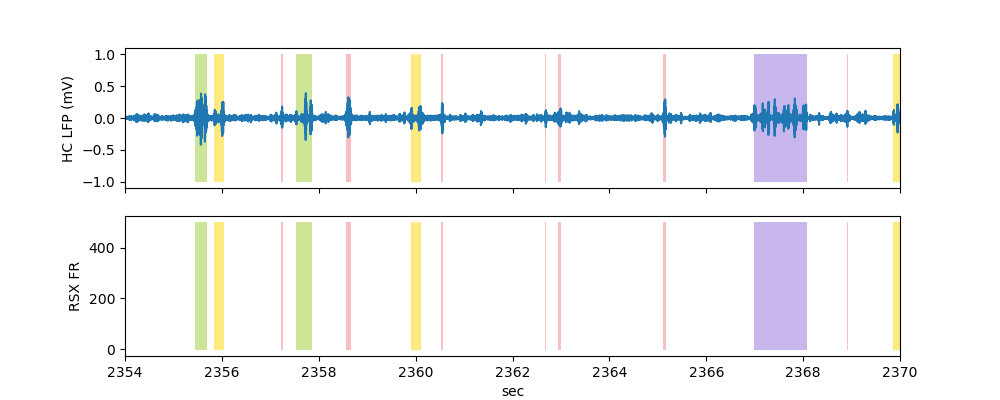

In [23]:
plt.close()
# ax = plt.gca()
# fig = plt.gcf()

red_patch = mpatches.Patch(color='lightcoral', label='singlet')
yellow_patch = mpatches.Patch(color='gold', label='doublet')
green_patch = mpatches.Patch(color='yellowgreen', label='triplet')
purple_patch = mpatches.Patch(color='mediumpurple', label='4+')
# ax.legend(handles=[red_patch, yellow_patch, green_patch, purple_patch])
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)
fig.set_size_inches((10, 4))

# for line in singles_doubled:
    # ax.axvline(sb1_time[line], color="red", lw=1)
# for line in doubles_doubled:
#     ax.axvline(sb1_time[line], color="orange", lw=1)
# for line in triples_doubled:
#     ax.axvline(sb1_time[line], color="green", lw=1)
# for line in longs_doubled:
#     ax.axvline(sb1_time[line], color="purple", lw=1)

axes[0].set_xlim(2354, 2370)
axes[0].plot(sb1_time, lfp)
# plt.title("ripple bursts in HC; spindles? in RSX")
i = 0
while i < len(singles_doubled):
    rect = Rectangle((sb1_time[singles_doubled[i]], -1), width=(sb1_time[singles_doubled[i+1]]-sb1_time[singles_doubled[i]]), height=2, facecolor='lightcoral', alpha=0.5)
    axes[0].add_patch(rect)
    i+=2
i = 0
while i < len(doubles_doubled):
    rect = Rectangle((sb1_time[doubles_doubled[i]], -1), width=sb1_time[doubles_doubled][i+1]-sb1_time[doubles_doubled][i], height=2, facecolor='gold', alpha=0.5)
    axes[0].add_patch(rect)
    i+=2
i = 0
while i < len(triples_doubled):
    rect = Rectangle((sb1_time[triples_doubled[i]], -1), width=sb1_time[triples_doubled][i+1]-sb1_time[triples_doubled][i], height=2, facecolor='yellowgreen', alpha=0.5)
    axes[0].add_patch(rect)
    i+=2
i = 0
while i < len(longs_doubled):
    rect = Rectangle((sb1_time[longs_doubled[i]], -1), width=sb1_time[longs_doubled][i+1]-sb1_time[longs_doubled][i], height=2, facecolor='mediumpurple', alpha=0.5)
    axes[0].add_patch(rect)
    i+=2
axes[0].set_ylabel("HC LFP (mV)")

axes[1].plot(rsxfr_time, rsxfr_data)
axes[1].set_ylabel("RSX FR")
i = 0
while i < len(singles_doubled):
    rect = Rectangle((sb1_time[singles_doubled[i]], -1), width=(sb1_time[singles_doubled[i+1]]-sb1_time[singles_doubled[i]]), height=500, facecolor='lightcoral', alpha=0.5)
    axes[1].add_patch(rect)
    i+=2
i = 0
while i < len(doubles_doubled):
    rect = Rectangle((sb1_time[doubles_doubled[i]], -1), width=sb1_time[doubles_doubled][i+1]-sb1_time[doubles_doubled][i], height=500, facecolor='gold', alpha=0.5)
    axes[1].add_patch(rect)
    i+=2
i = 0
while i < len(triples_doubled):
    rect = Rectangle((sb1_time[triples_doubled[i]], -1), width=sb1_time[triples_doubled][i+1]-sb1_time[triples_doubled][i], height=500, facecolor='yellowgreen', alpha=0.5)
    axes[1].add_patch(rect)
    i+=2
i = 0
while i < len(longs_doubled):
    rect = Rectangle((sb1_time[longs_doubled[i]], -1), width=sb1_time[longs_doubled][i+1]-sb1_time[longs_doubled][i], height=500, facecolor='mediumpurple', alpha=0.5)
    axes[1].add_patch(rect)
    i+=2
plt.xlabel("sec")
plt.show()



## RSX FRs corresponding to ripples

In [4]:
sb1_struct = loadmat(CAI_SB1, struct_as_record=False)

sb1_time, sb1_data, sample_rate = get_data(
    sb1_struct, name=LFP_NAMES[1])  # RSX and HIP
sb1_data = append_avg_rsx(sb1_data)
lfp = butter_filter(sb1_data[:, 6], lowcut=HC_FILTER_LOW, highcut=HC_FILTER_HI, fs=sample_rate, order=HC_FILTER_ORDER, type="bandpass")

rsxfr_time = np.squeeze(sb1_struct["RSXfr"][0][0].timestamp)
rsxfr_count = np.squeeze(sb1_struct["RSXfr"][0][0].count)
rsxfr_data = np.squeeze(sb1_struct["RSXfr"][0][0].data)

NameError: name 'doubles_doubled' is not defined

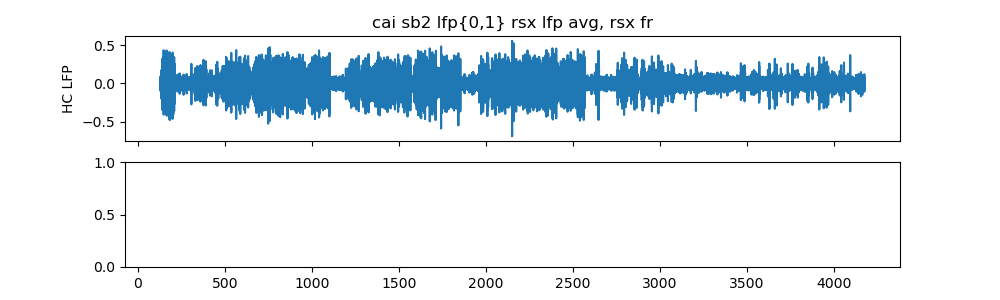

In [47]:
%matplotlib ipympl

plt.close()
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)
fig.canvas.header_visible = False
fig.set_size_inches((10, 3))
# plt.xlim(1981.3, 1981.5)
# plt.xlim(blocks[2][0]/1000 + smxfr_time[0], blocks[2][0]/1000 + smxfr_time[0]+4)
# plt.xlim(8445, 8449)
# plt.xlim(time[0], time[0]+1)

lfp = butter_bandpass_filter(sb1_data[:, 6], lowcut=HC_FILTER_LOW, highcut=HC_FILTER_HI, fs=sample_rate, order=HC_FILTER_ORDER)
# axes[0].plot(time[:num_points], smx_avg[:num_points])
axes[0].plot(sb1_time, np.squeeze(lfp))
axes[0].set_ylabel("HC LFP")
axes[0].set_title("cai sb2 lfp{0,1} rsx lfp avg, rsx fr")
for doubles in doubles_doubled:
    axes[0].axvline(sb1_time[doubles], color="red", lw=1)

axes[1].plot(rsxfr_time, rsxfr_data)
axes[1].set_ylabel("RSX FR")
for doubles in doubles_doubled:
    axes[1].axvline(sb1_time[doubles], color="red", lw=1)

/var/folders/0y/gsy94xwd3n70y8tm3t9zmdtw0000gn/T/ipykernel_61917/1653931220.py:204: RuntimeWarning: invalid value encountered in true_divide
  return (data - np.min(data)) / (np.max(data) - np.min(data))


Text(0, 0.5, 'longs')

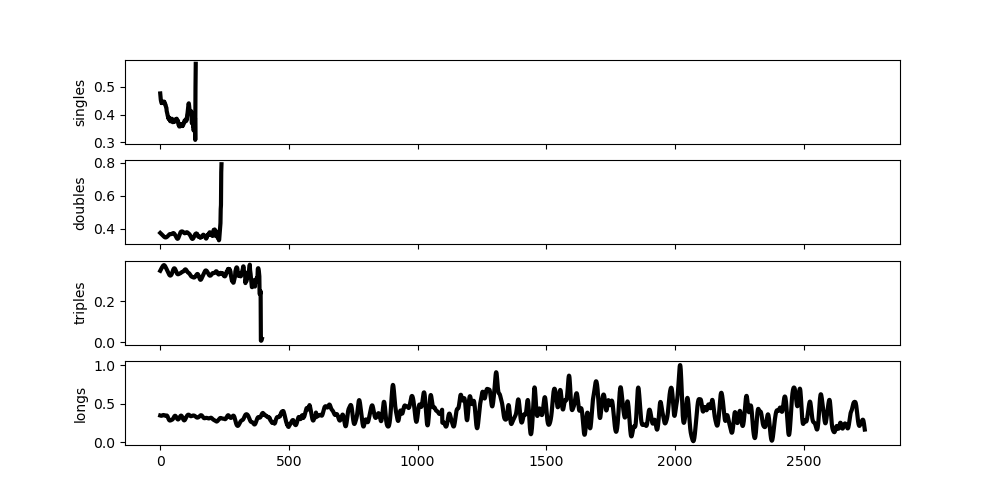

: 

In [ ]:
plt.close()
fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True)
fig.canvas.header_visible = False
fig.set_size_inches((10, 5))

# singles
single_events = []
i = 0
while i < len(singles_doubled):
    single_events.append(rsxfr_data[lfp_sample2fr_sample(singles_doubled[i], sb1_time, rsxfr_time):lfp_sample2fr_sample(singles_doubled[i+1], sb1_time, rsxfr_time)])
    i+=2
single_events = [normalize(event) for event in single_events[2:]]
max_len = len(max(single_events, key=len))
padded = []
for event in single_events:
    # pad every event to same length
    # axes[0].plot(event)
    pad = np.pad(event, (0, max_len-len(event)), constant_values=(np.nan))
    padded.append(pad)
axes[0].plot(np.nanmean(padded, axis=0), lw=3, color="black")
axes[0].set_ylabel("singles")

#doubles 
double_events = []
i = 0
while i < len(doubles_doubled):
    double_events.append(rsxfr_data[lfp_sample2fr_sample(doubles_doubled[i], sb1_time, rsxfr_time):lfp_sample2fr_sample(doubles_doubled[i+1], sb1_time, rsxfr_time)])
    i+=2
double_events = [normalize(event) for event in double_events]
max_len = len(max(double_events, key=len))
padded = []
for event in double_events:
    # pad every event to same length
    # axes[1].plot(event)
    pad = np.pad(event, (0, max_len-len(event)), constant_values=(np.nan))
    padded.append(pad)
axes[1].plot(np.nanmean(padded, axis=0), lw=3, color="black")
axes[1].set_ylabel("doubles")

# triples 
triple_events = []
i = 0
while i < len(triples_doubled):
    triple_events.append(rsxfr_data[lfp_sample2fr_sample(triples_doubled[i], sb1_time, rsxfr_time):lfp_sample2fr_sample(triples_doubled[i+1], sb1_time, rsxfr_time)])
    i+=2
triple_events = [normalize(event) for event in triple_events]
max_len = len(max(triple_events, key=len))
padded = []
for event in triple_events:
    # pad every event to same length
    # axes[2].plot(event)
    pad = np.pad(event, (0, max_len-len(event)), constant_values=(np.nan))
    padded.append(pad)
axes[2].plot(np.nanmean(padded, axis=0), lw=3, color="black")
axes[2].set_ylabel("triples")

# longs 
long_events = []
i = 0
while i < len(longs_doubled):
    long_events.append(rsxfr_data[lfp_sample2fr_sample(longs_doubled[i], sb1_time, rsxfr_time):lfp_sample2fr_sample(longs_doubled[i+1], sb1_time, rsxfr_time)])
    i+=2
long_events = [normalize(event) for event in long_events]
max_len = len(max(long_events, key=len))
padded = []
for event in long_events:
#     # pad every event to same length
#     axes[3].plot(event)
    pad = np.pad(event, (0, max_len-len(event)), constant_values=(np.nan))
    padded.append(pad)
axes[3].plot(np.nanmean(padded, axis=0), lw=3, color="black")
axes[3].set_ylabel("longs")

## RSX spindle search

In [5]:
eps = 15  # doesn't change much when decreasing more than 1e-3, omits many things if set abow 1e-1. but maybe should be lower, doesn't look like many k complexes for now
suppressed = np.where(rsxfr_data <= eps, 1, 0)
print(np.sum(suppressed)/len(rsxfr_time))

i = 0
prev = 0
ones_count = 0
thresh = 60
blocks = []
while i < len(rsxfr_data):
    if suppressed[i] == 1:
        ones_count+=1
    else:  # if current value is 0
        if prev == 1:
            if ones_count > thresh:
                blocks.append((i-1-ones_count, i-1))       
            ones_count = 0
    prev = suppressed[i]
    i+=1

0.1258998326944547


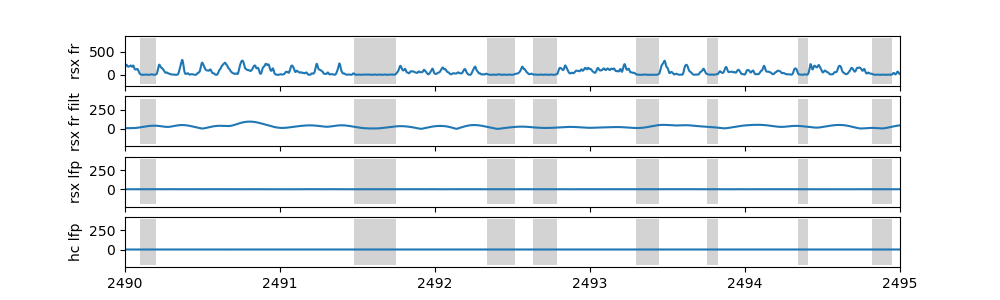

In [8]:
%matplotlib ipympl
plt.close()
fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True)
fig.canvas.header_visible = False
fig.set_size_inches((10, 3))

plt.xlim(2490, 2495)
axes[0].plot(rsxfr_time, rsxfr_data)
axes[0].set_ylabel("rsx fr")
for block in blocks:
    rect = Rectangle((rsxfr_time[block[0]], -200), width=rsxfr_time[block[1]]-rsxfr_time[block[0]], height=1000, facecolor='lightgrey')
    axes[0].add_patch(rect)
    # axes[0].axvline(rsxfr_time[block[0]], color="green", lw=1)
    # axes[0].axvline(rsxfr_time[block[1]], color="red", lw=1)

fr_filt = butter_bandpass_filter(rsxfr_data, 9, 15, 1000, order=3)
envelope = np.abs(hilbert(fr_filt))
# std = statistics.stdev(envelope)  # not needed, slow
mean = np.mean(envelope)
# axes[1].plot(rsxfr_time, fr_filt)
axes[1].plot(rsxfr_time, envelope)
# axes[1].axhline(mean)
axes[1].set_ylabel("rsx fr filt")
for block in blocks:
    # axes[1].axvline(rsxfr_time[block[0]], color="green", lw=1)
    # axes[1].axvline(rsxfr_time[block[1]], color="red", lw=1)
    rect = Rectangle((rsxfr_time[block[0]], -200), width=rsxfr_time[block[1]]-rsxfr_time[block[0]], height=600, facecolor='lightgrey')
    axes[1].add_patch(rect)

rsx_lfp_avg = sb1_data[:, -1]
axes[2].plot(sb1_time, rsx_lfp_avg)
axes[2].set_ylabel("rsx lfp")
for block in blocks:
    rect = Rectangle((rsxfr_time[block[0]], -200), width=rsxfr_time[block[1]]-rsxfr_time[block[0]], height=600, facecolor='lightgrey')
    axes[2].add_patch(rect)

hc_lfp = butter_bandpass_filter(sb1_data[:, 6], lowcut=HC_FILTER_LOW, highcut=HC_FILTER_HI, fs=sample_rate, order=HC_FILTER_ORDER) 
axes[3].plot(sb1_time, hc_lfp)
axes[3].set_ylabel("hc lfp")
for block in blocks:
    rect = Rectangle((rsxfr_time[block[0]], -200), width=rsxfr_time[block[1]]-rsxfr_time[block[0]], height=600, facecolor='lightgrey')
    axes[3].add_patch(rect)


In [9]:
print(sb1_data.shape)

(8107008, 9)


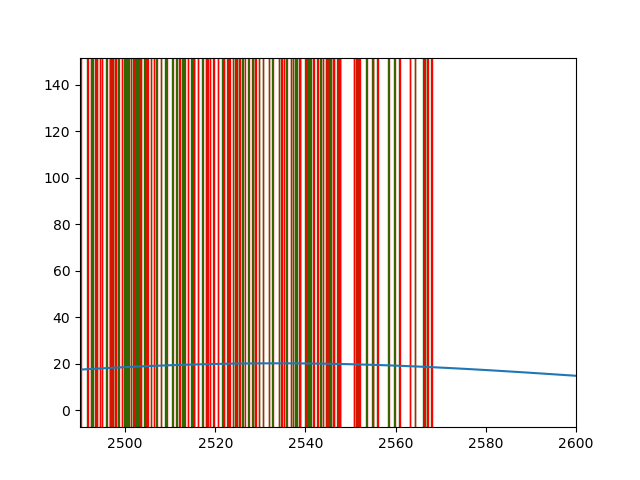

In [39]:
plt.close()


for block in blocks:
    plt.axvline(rsxfr_time[block[0]], color="green", lw=1)
    plt.axvline(rsxfr_time[block[1]], color="red", lw=1)
plt.xlim(2490, 2600)
# plt.axhline(mean+2*std, color="r")
plt.plot(envelope)

## motif detection

In [1]:
num_points = 500000

dt = sb1_time[1]-sb1_time[0]
m = int(1/10/dt)  # 10hz converted to num of sample points
mp = stumpy.stump(sb1_data[:num_points, -1], m)


NameError: name 'sb1_time' is not defined

In [43]:
# Get top 10 most found motif (?)
motifs = stumpy.motifs(sb1_data[:num_points, -1], mp[:,0], max_matches=10, max_motifs=1)
motif_ids = motifs[1][0]

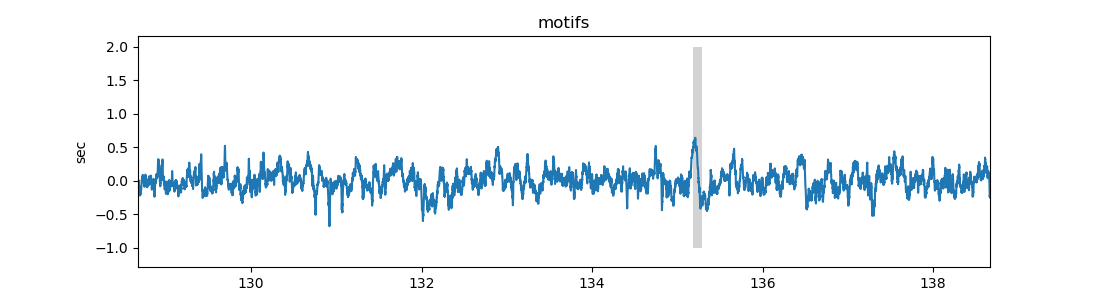

In [44]:
plt.close()

fig = plt.gcf()
fig.canvas.header_visible = False
ax = plt.gca()
plt.plot(sb1_time[:num_points], sb1_data[:num_points, -1])
for id in motif_ids:
    rect = Rectangle((sb1_time[id], -1), m*dt, 3, facecolor='lightgrey')
    ax.add_patch(rect)

ax.set_xlim(sb1_time[0], sb1_time[0]+10)
ax.set_ylabel('mV')
ax.set_ylabel('sec')
ax.set_title("motifs")
fig.set_size_inches(11, 3)
plt.show()


86003
86001
13060
13058


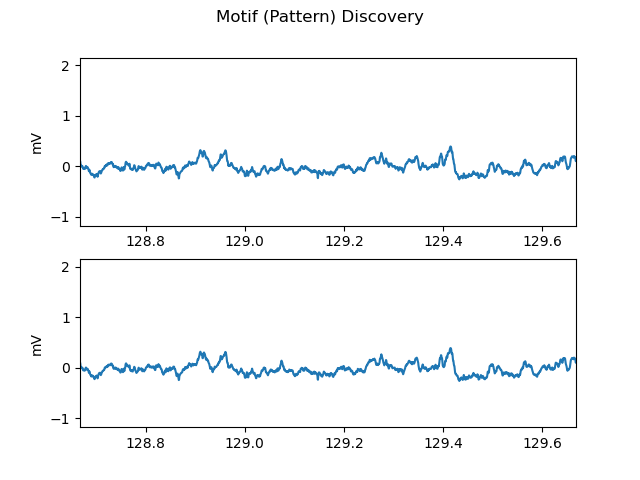

In [ ]:
# fig, axs = plt.subplots(2, sharex=False, gridspec_kw={'hspace': 0})
fig, axes = plt.subplots(10)
plt.suptitle('motifs')
fig.canvas.header_visible = False

# TODO: isolate all motifs and plot on same axes
# TODO: visualize all motifs using squares across the num_points of time series

# for i, ax in enumerate(axes):
#     motif = motifs[1][i]
#     ax.plot(sb1_time[:num_points], sb1_data[:num_points, -1])
#     ax.set_xlim(sb1_time[0], sb1_time[0]+1)
#     rect = Rectangle((sb1_time[motif], -1), m*dt, 3, facecolor='lightgrey')
#     ax.add_patch(rect)

# axs[0].plot(sb1_time[:num_points], sb1_data[:num_points, -1])
# axs[0].set_xlim(sb1_time[0], sb1_time[0]+1)
# axs[0].set_ylabel('mV')
# rect = Rectangle((sb1_time[motif_idx0], -1), m*dt, 3, facecolor='lightgrey')
# axs[0].add_patch(rect)
# rect = Rectangle((sb1_time[nearest_neighbor_idx0], -1), m*dt, 3, facecolor='lightgrey')
# axs[0].add_patch(rect)
# axs[1].plot(sb1_time[:num_points], sb1_data[:num_points, -1])
# axs[1].set_xlim(sb1_time[0], sb1_time[0]+1)
# axs[1].set_ylabel('mV')
# rect = Rectangle((sb1_time[motif_idx1], -1), m*dt, 3, facecolor='lightgrey')
# axs[1].add_patch(rect)
# rect = Rectangle((sb1_time[nearest_neighbor_idx1], -1), m*dt, 3, facecolor='lightgrey')
# axs[1].add_patch(rect)
# plt.show()
